In [1]:
import pandas as pd

In [2]:
## KAGGLE

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
# train = pd.read_csv('../input/sentimen-restoran/preprocessed_train.csv')
# test = pd.read_csv('../input/sentimen-restoran/preprocessed_test.csv')

In [4]:
train = pd.read_csv('data/preprocessed_train.csv')
test = pd.read_csv('data/preprocessed_test.csv')

In [5]:
train['sentiment'].value_counts()

1    1200
0     580
Name: sentiment, dtype: int64

In [6]:
train.shape

(1780, 14)

In [7]:
sentiment_to_id = {'positive': 1, 'negative': 0}
id_to_sentiment = {1: 'positive', 0: 'negative'}

### Feature Selection (part 1)

In [8]:
X_test = test['cleaned_text']

X_test_sent_barasa = test[['barasa_total_pos_word', 'barasa_total_neg_word', \
                            'barasa_mean_pos_sentiment_val', 'barasa_mean_neg_sentiment_val']]

# X_test_text_sent_barasa = X_test_sent_barasa.copy() + tfidf vector of cleaned text

X_test_sent_trans = test[['trans_total_pos_word', 'trans_total_neg_word', \
                            'trans_mean_pos_sentiment_val', 'trans_mean_neg_sentiment_val']]

# X_test_text_sent_trans = X_test_sent_trans.copy()+ tfidf vector of cleaned text

y_test = test['sentiment']

### CBOW using gensim.word2vec

In [9]:
# import sys
# !{sys.executable} -m pip install gensim

In [10]:
from gensim.models import word2vec

In [11]:
sentences = []

for text in train['cleaned_text']:
    sentences.append(text.split())

In [12]:
# Initializing the train model
print("Training model....")
# CBOW, because when training word2vec model not explicitly using parameter sg=1 (skip-gram=1)
model_w2v = word2vec.Word2Vec(sentences)

Training model....


In [13]:
# To make the model memory efficient
model_w2v.init_sims(replace=True)

#### create train & test vector

In [14]:
#Converting Index2Word which is a list to a set for better speed in the execution.
index2word_set = set(model_w2v.wv.index2word)

In [15]:
# Function to average all word vectors in a text
def featureVecMethod(words, model_w2v, num_features, w2v_index2word=index2word_set):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features, dtype="float32")
    nwords = 0
    
    for word in  words:
        if word in w2v_index2word:
            nwords = nwords + 1
            featureVec = np.add(featureVec, model_w2v.wv[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    
    return featureVec

In [16]:
import numpy as np

In [17]:
# Function for calculating the average feature vector
# texts: text from all row
def getAvgFeatureVecs(texts, model_w2v, num_features, w2v_index2word=index2word_set):
    counter = 0
    FeatureVecs = np.zeros((len(texts), num_features), dtype="float32")
    
    # for each row
    for text in texts:
        FeatureVecs[counter] = featureVecMethod(text, model_w2v, num_features, w2v_index2word)
        counter = counter+1
        
    return FeatureVecs

In [18]:
num_features = model_w2v.wv.vectors.shape[1]

In [19]:
trainDataVecs = getAvgFeatureVecs(train['cleaned_text'], model_w2v, num_features)
testDataVecs = getAvgFeatureVecs(test['cleaned_text'], model_w2v, num_features)

In [20]:
trainDataVecs.shape

(1780, 100)

In [21]:
type(trainDataVecs)

numpy.ndarray

### SMOTE

In [22]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [23]:
train_vect = pd.DataFrame(data=trainDataVecs[0:,0:],
                index=[i for i in range(trainDataVecs.shape[0])],
                columns=['f'+str(i) for i in range(trainDataVecs.shape[1])])

In [24]:
train_vect = train_vect.reset_index(drop=True)
train = train.reset_index(drop=True)

In [25]:
X_train = pd.concat([train_vect, train[['barasa_total_pos_word', 'barasa_total_neg_word', \
                            'barasa_mean_pos_sentiment_val', 'barasa_mean_neg_sentiment_val', \
                            'trans_total_pos_word', 'trans_total_neg_word', \
                            'trans_mean_pos_sentiment_val', 'trans_mean_neg_sentiment_val']]], axis=1, sort=False)

In [26]:
X_train.head()

f0        f1        f2        f3        f4        f5        f6  \
0  0.016099  0.068016 -0.118798 -0.124059  0.028043 -0.098639 -0.012997   
1  0.016580  0.068026 -0.118375 -0.124203  0.028550 -0.098899 -0.013491   
2  0.016134  0.068177 -0.118569 -0.123833  0.027915 -0.098651 -0.013133   
3  0.017029  0.067601 -0.118735 -0.123397  0.027915 -0.097927 -0.012149   
4  0.016292  0.067787 -0.118771 -0.123907  0.027958 -0.098548 -0.012992   

         f7        f8        f9  ...       f98       f99  \
0  0.137633  0.007374 -0.029564  ...  0.056103  0.165837   
1  0.136992  0.008167 -0.029199  ...  0.055079  0.166363   
2  0.138341  0.007582 -0.029696  ...  0.056100  0.165467   
3  0.136622  0.007318 -0.030540  ...  0.057174  0.166054   
4  0.137240  0.007518 -0.029886  ...  0.055956  0.165975   

   barasa_total_pos_word  barasa_total_neg_word  \
0                     19                     19   
1                      7                     11   
2                      6                      5   
3                      4                      4   
4                     21                     26   

   barasa_mean_pos_sentiment_val  barasa_mean_neg_sentiment_val  \
0                       0.078069                       0.149732   
1                       0.095732                       0.136639   
2                       0.087889                       0.104795   
3                       0.040634                       0.085928   
4                       0.119401                       0.149148   

   trans_total_pos_word  trans_total_neg_word  trans_mean_pos_sentiment_val  \
0                    18                    14                      0.049165   
1                     8                    12                      0.102066   
2                    10                     9                      0.068739   
3                     2                     3                      0.028846   
4                    24                    27                      0.094519   

   trans_mean_neg_sentiment_val  
0                      0.075428  
1                      0.133502  
2                      0.129534  
3                      0.096154  
4                      0.077969  

[5 rows x 108 columns]

In [27]:
X_train.shape

(1780, 108)

In [28]:
y_train = train['sentiment']

In [29]:
sm = SMOTE(random_state=1)

X_res, y_res = sm.fit_resample(X_train, y_train)

train = X_res.copy()
train['sentiment'] = y_res

In [30]:
train['sentiment'].value_counts()

1    1200
0    1200
Name: sentiment, dtype: int64

In [31]:
train.head()

f0        f1        f2        f3        f4        f5        f6  \
0  0.016099  0.068016 -0.118798 -0.124059  0.028043 -0.098639 -0.012997   
1  0.016580  0.068026 -0.118375 -0.124203  0.028550 -0.098899 -0.013491   
2  0.016134  0.068177 -0.118569 -0.123833  0.027915 -0.098651 -0.013133   
3  0.017029  0.067601 -0.118735 -0.123397  0.027915 -0.097927 -0.012149   
4  0.016292  0.067787 -0.118771 -0.123907  0.027958 -0.098548 -0.012992   

         f7        f8        f9  ...       f99  barasa_total_pos_word  \
0  0.137633  0.007374 -0.029564  ...  0.165837                     19   
1  0.136992  0.008167 -0.029199  ...  0.166363                      7   
2  0.138341  0.007582 -0.029696  ...  0.165467                      6   
3  0.136622  0.007318 -0.030540  ...  0.166054                      4   
4  0.137240  0.007518 -0.029886  ...  0.165975                     21   

   barasa_total_neg_word  barasa_mean_pos_sentiment_val  \
0                     19                       0.078069   
1                     11                       0.095732   
2                      5                       0.087889   
3                      4                       0.040634   
4                     26                       0.119401   

   barasa_mean_neg_sentiment_val  trans_total_pos_word  trans_total_neg_word  \
0                       0.149732                    18                    14   
1                       0.136639                     8                    12   
2                       0.104795                    10                     9   
3                       0.085928                     2                     3   
4                       0.149148                    24                    27   

   trans_mean_pos_sentiment_val  trans_mean_neg_sentiment_val  sentiment  
0                      0.049165                      0.075428          0  
1                      0.102066                      0.133502          0  
2                      0.068739                      0.129534          0  
3                      0.028846                      0.096154          0  
4                      0.094519                      0.077969          0  

[5 rows x 109 columns]

In [32]:
train.shape

(2400, 109)

### Feature Selection (part 2)

In [33]:
train_vect = train.drop(columns=['barasa_total_pos_word', 'barasa_total_neg_word', \
                            'barasa_mean_pos_sentiment_val', 'barasa_mean_neg_sentiment_val', \
                            'trans_total_pos_word', 'trans_total_neg_word', \
                            'trans_mean_pos_sentiment_val', 'trans_mean_neg_sentiment_val', \
                            'sentiment']).to_numpy()

X_train_sent_barasa = train[['barasa_total_pos_word', 'barasa_total_neg_word', \
                            'barasa_mean_pos_sentiment_val', 'barasa_mean_neg_sentiment_val']]

X_train_sent_trans = train[['trans_total_pos_word', 'trans_total_neg_word', \
                            'trans_mean_pos_sentiment_val', 'trans_mean_neg_sentiment_val']]

In [34]:
y_train = train['sentiment']

In [35]:
type(train_vect)

numpy.ndarray

In [36]:
train_vect.shape

(2400, 100)

In [37]:
X_train = train_vect

X_train_text_sent_barasa = np.concatenate((train_vect, X_train_sent_barasa), axis=1)
X_train_text_sent_trans = np.concatenate((train_vect, X_train_sent_trans), axis=1)

In [38]:
X_test = testDataVecs
X_test_text_sent_barasa = np.concatenate((testDataVecs, X_test_sent_barasa), axis=1)
X_test_text_sent_trans = np.concatenate((testDataVecs, X_test_sent_trans), axis=1)

### Train

In [39]:
# Library for Deep Learning
from keras import backend as K

In [40]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### set random seed

In [42]:
import tensorflow as tf

In [43]:
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [44]:
import random
# import numpy as np

#### 1. Base Model (using cleaned_text only)

In [45]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [46]:
X_train.shape

(2400, 100)

In [47]:
type(X_train)

numpy.ndarray

In [48]:
# Reshaping X_train & X_test
X_train = X_train[:, :, None]
X_test = X_test[:, :, None]

In [49]:
X_train.shape

(2400, 100, 1)

In [50]:
base_model = Sequential()
base_model.add(LSTM(10, dropout=0.2, input_shape=X_train.shape[1:]))
base_model.add(layers.Dense(8, activation='relu'))
base_model.add(Dropout(0.2))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [51]:
base_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', f1_m])

In [52]:
EPOCHS = 10
BATCH_SIZE = 1024

history = base_model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 1s 599us/step - loss: 0.6935 - accuracy: 0.4827 - f1_m: 0.4946 - val_loss: 0.6954 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 2/10
1680/1680 [==============================] - 0s 109us/step - loss: 0.6919 - accuracy: 0.6548 - f1_m: 0.7934 - val_loss: 0.6985 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 3/10
1680/1680 [==============================] - 0s 148us/step - loss: 0.6907 - accuracy: 0.6548 - f1_m: 0.7900 - val_loss: 0.7017 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 4/10
1680/1680 [==============================] - 0s 110us/step - loss: 0.6895 - accuracy: 0.6548 - f1_m: 0.7898 - val_loss: 0.7050 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 5/10
1680/1680 [==============================] - 0s 102us/step - loss: 0.6879 - accuracy: 0.6548 - f1_m: 0.7922 - val_loss: 0.7085 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 6/10
1680/1680 [==============================]

In [53]:
def save_model(model, FILE_NAME):
    # serialize model to YAML
    model_yaml = model.to_yaml()
    with open(FILE_NAME +'.yaml', "w") as yaml_file:
        yaml_file.write(model_yaml)
    # serialize weights to HDF5
    model.save_weights(FILE_NAME +'.h5')
    print("Saved model to disk")

In [54]:
save_model(base_model, 'model/LSTM smote_cbow_base')

Saved model to disk


In [55]:
history.history

{'val_loss': [0.6954200863838196,
  0.6984638571739197,
  0.7017034292221069,
  0.705021858215332,
  0.7084938287734985,
  0.7121290564537048,
  0.7159371972084045,
  0.7199422121047974,
  0.7242072224617004,
  0.7287583351135254],
 'val_accuracy': [0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272],
 'val_f1_m': [0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635],
 'loss': [0.6935023160207839,
  0.6919475044522967,
  0.6906870779537019,
  0.6895433511052813,
  0.6878698314939227,
  0.6865525495438348,
  0.6854194101833162,
  0.6837751082011632,
  0.6827162356603713,
  0.6807621802602496],
 'accuracy': [0.4827381,
  0.6547619,
  0.6547619,
  0.6547

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

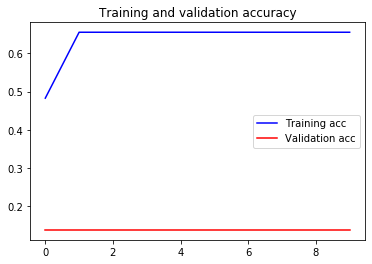

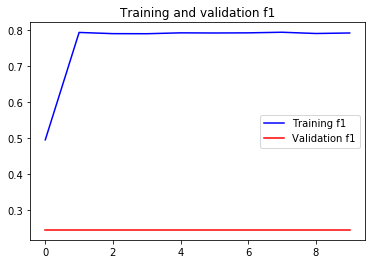

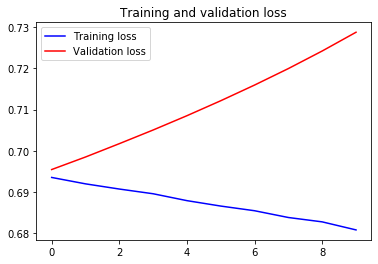

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [58]:
score = base_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 65us/step

f1: 0.786885142326355
accuracy: 0.6486486196517944
LOSS: 0.6800957918167114


In [59]:
# predict probabilities for val set
y_pred_probs = base_model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = (base_model.predict(X_test) > 0.5).astype("int32")

In [60]:
y_pred

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [61]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [62]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

In [63]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.648649
Precision: 0.648649
Recall: 1.000000
F1 score: 0.786885
Kappa score: 0.000000


In [64]:
from sklearn.metrics import confusion_matrix

Text(0.5, 15.0, 'Predicted')

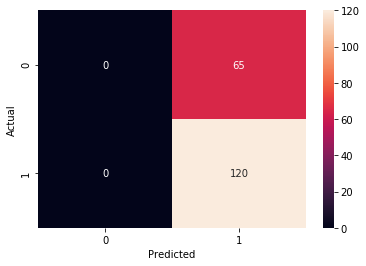

In [65]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### 2. Barasa Sentiment Model

In [66]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [67]:
X_train_sent_barasa.shape

(2400, 4)

In [68]:
type(X_train_sent_barasa)

pandas.core.frame.DataFrame

In [69]:
X_train_sent_barasa = X_train_sent_barasa.to_numpy()
X_test_sent_barasa = X_test_sent_barasa.to_numpy()

In [70]:
type(X_train_sent_barasa)

numpy.ndarray

In [71]:
X_train_sent_barasa.shape

(2400, 4)

In [72]:
# Reshaping X_train & X_test
X_train_sent_barasa = X_train_sent_barasa[:, :, None]
X_test_sent_barasa = X_test_sent_barasa[:, :, None]

In [73]:
X_train_sent_barasa.shape

(2400, 4, 1)

In [74]:
model = Sequential()
model.add(LSTM(10, dropout=0.2, input_shape=X_train_sent_barasa.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', f1_m])

In [76]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train_sent_barasa, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 1s 406us/step - loss: 0.7421 - accuracy: 0.4077 - f1_m: 0.3302 - val_loss: 0.6091 - val_accuracy: 0.8611 - val_f1_m: 0.0000e+00
Epoch 2/10
1680/1680 [==============================] - 0s 9us/step - loss: 0.7302 - accuracy: 0.4631 - f1_m: 0.4682 - val_loss: 0.6160 - val_accuracy: 0.8611 - val_f1_m: 0.0000e+00
Epoch 3/10
1680/1680 [==============================] - 0s 8us/step - loss: 0.7288 - accuracy: 0.4512 - f1_m: 0.4517 - val_loss: 0.6230 - val_accuracy: 0.8611 - val_f1_m: 0.0000e+00
Epoch 4/10
1680/1680 [==============================] - 0s 8us/step - loss: 0.7230 - accuracy: 0.4601 - f1_m: 0.4622 - val_loss: 0.6299 - val_accuracy: 0.8611 - val_f1_m: 0.0000e+00
Epoch 5/10
1680/1680 [==============================] - 0s 8us/step - loss: 0.7172 - accuracy: 0.4708 - f1_m: 0.4868 - val_loss: 0.6368 - val_accuracy: 0.8611 - val_f1_m: 0.0000e+00
Epoch 6/10
1680/1680 [===================

In [77]:
save_model(model, 'model/LSTM smote_cbow_sent_barasa')

Saved model to disk


In [78]:
history.history

{'val_loss': [0.6090835332870483,
  0.6160178184509277,
  0.6229721903800964,
  0.6299213767051697,
  0.6368345618247986,
  0.6437833905220032,
  0.6507350206375122,
  0.6577404737472534,
  0.6647713780403137,
  0.6718354225158691],
 'val_accuracy': [0.8611111044883728,
  0.8611111044883728,
  0.8611111044883728,
  0.8611111044883728,
  0.8611111044883728,
  0.8611111044883728,
  0.8583333492279053,
  0.8569444417953491,
  0.855555534362793,
  0.855555534362793],
 'val_f1_m': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.019230762496590614,
  0.03738316521048546,
  0.07142855226993561,
  0.1746031492948532],
 'loss': [0.7420740842819213,
  0.7302485988253639,
  0.7287902179218474,
  0.7229870483988807,
  0.7171917160352071,
  0.7166090743882315,
  0.710372771535601,
  0.7090714886074975,
  0.7025412037259057,
  0.7026690993990217],
 'accuracy': [0.4077381,
  0.46309525,
  0.45119047,
  0.46011904,
  0.47083333,
  0.4434524,
  0.46071428,
  0.4434524,
  0.4684524,
  0.43928573],
 'f1_m':

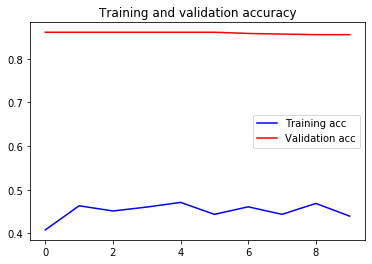

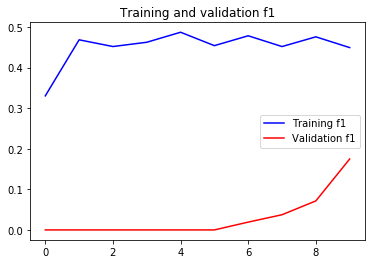

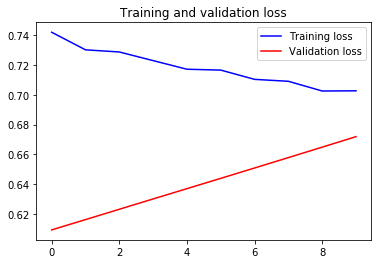

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [80]:
score = model.evaluate(X_test_sent_barasa, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 8us/step

f1: 0.1230769157409668
accuracy: 0.3837837874889374
LOSS: 0.6981852054595947


In [81]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test_sent_barasa, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test_sent_barasa, verbose=0)

In [82]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [83]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [84]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.383784
Precision: 0.800000
Recall: 0.066667
F1 score: 0.123077
Kappa score: 0.025866


Text(0.5, 15.0, 'Predicted')

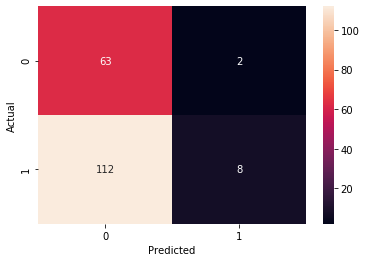

In [85]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### 3. Barasa Sentiment Model + Cleaned Text

In [86]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [87]:
X_train_text_sent_barasa.shape

(2400, 104)

In [88]:
type(X_train_text_sent_barasa)

numpy.ndarray

In [89]:
# Reshaping X_train & X_test
X_train_text_sent_barasa = X_train_text_sent_barasa[:, :, None]
X_test_text_sent_barasa = X_test_text_sent_barasa[:, :, None]

In [90]:
X_train_text_sent_barasa.shape

(2400, 104, 1)

In [91]:
model = Sequential()
model.add(LSTM(10, dropout=0.2, input_shape=X_train_text_sent_barasa.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', f1_m])

In [93]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train_text_sent_barasa, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 1s 466us/step - loss: 0.7430 - accuracy: 0.4077 - f1_m: 0.3302 - val_loss: 0.6071 - val_accuracy: 0.8611 - val_f1_m: 0.0000e+00
Epoch 2/10
1680/1680 [==============================] - 0s 104us/step - loss: 0.7315 - accuracy: 0.4631 - f1_m: 0.4682 - val_loss: 0.6142 - val_accuracy: 0.8611 - val_f1_m: 0.0000e+00
Epoch 3/10
1680/1680 [==============================] - 0s 94us/step - loss: 0.7298 - accuracy: 0.4512 - f1_m: 0.4517 - val_loss: 0.6215 - val_accuracy: 0.8611 - val_f1_m: 0.0000e+00
Epoch 4/10
1680/1680 [==============================] - 0s 113us/step - loss: 0.7238 - accuracy: 0.4601 - f1_m: 0.4622 - val_loss: 0.6287 - val_accuracy: 0.8611 - val_f1_m: 0.0000e+00
Epoch 5/10
1680/1680 [==============================] - 0s 96us/step - loss: 0.7178 - accuracy: 0.4708 - f1_m: 0.4868 - val_loss: 0.6360 - val_accuracy: 0.8611 - val_f1_m: 0.0000e+00
Epoch 6/10
1680/1680 [=============

In [94]:
save_model(model, 'model/LSTM smote_cbow_text_sent_barasa')

Saved model to disk


In [95]:
history.history

{'val_loss': [0.6070951819419861,
  0.6142040491104126,
  0.6214555501937866,
  0.6286913752555847,
  0.6359788775444031,
  0.64336758852005,
  0.6508018970489502,
  0.6583340764045715,
  0.6659273505210876,
  0.6735931634902954],
 'val_accuracy': [0.8611111044883728,
  0.8611111044883728,
  0.8611111044883728,
  0.8611111044883728,
  0.8611111044883728,
  0.862500011920929,
  0.8583333492279053,
  0.8583333492279053,
  0.855555534362793,
  0.8458333611488342],
 'val_f1_m': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.019801978021860123,
  0.019230762496590614,
  0.0727272629737854,
  0.08771927654743195,
  0.1777777373790741],
 'loss': [0.7430423492477054,
  0.7315155755905878,
  0.72984896784737,
  0.7238249148641314,
  0.7177518861634391,
  0.71700698080517,
  0.7104116093544733,
  0.708842366649991,
  0.7021114082563491,
  0.7018590575172787],
 'accuracy': [0.4077381,
  0.46309525,
  0.45119047,
  0.46011904,
  0.47083333,
  0.4434524,
  0.46071428,
  0.4434524,
  0.4684524,
  0.44166666]

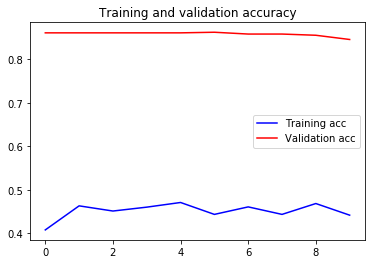

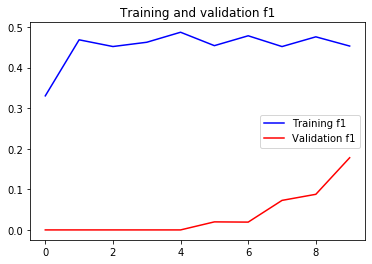

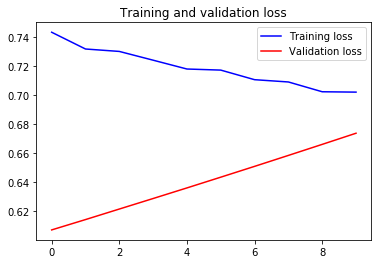

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [97]:
score = model.evaluate(X_test_text_sent_barasa, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 52us/step

f1: 0.16417907178401947
accuracy: 0.39459457993507385
LOSS: 0.6972625851631165


In [98]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test_text_sent_barasa, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test_text_sent_barasa, verbose=0)

In [99]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [100]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [101]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.394595
Precision: 0.785714
Recall: 0.091667
F1 score: 0.164179
Kappa score: 0.033131


Text(0.5, 15.0, 'Predicted')

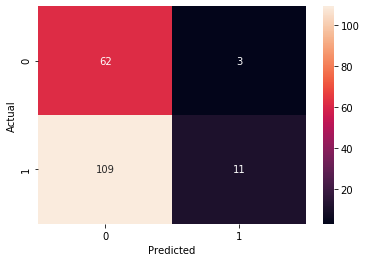

In [102]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### 4. Trans Sentiment Model

In [103]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [104]:
X_train_sent_trans.shape

(2400, 4)

In [105]:
type(X_train_sent_trans)

pandas.core.frame.DataFrame

In [106]:
X_train_sent_trans = X_train_sent_trans.to_numpy()
X_test_sent_trans = X_test_sent_trans.to_numpy()

In [107]:
type(X_train_sent_trans)

numpy.ndarray

In [108]:
X_train_sent_trans.shape

(2400, 4)

In [109]:
# Reshaping X_train & X_test
X_train_sent_trans = X_train_sent_trans[:, :, None]
X_test_sent_trans = X_test_sent_trans[:, :, None]

In [110]:
X_train_sent_trans.shape

(2400, 4, 1)

In [111]:
model = Sequential()
model.add(LSTM(10, dropout=0.2, input_shape=X_train_sent_trans.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [112]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', f1_m])

In [113]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train_sent_trans, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 1s 334us/step - loss: 0.7309 - accuracy: 0.4101 - f1_m: 0.3427 - val_loss: 0.6228 - val_accuracy: 0.8333 - val_f1_m: 0.0909
Epoch 2/10
1680/1680 [==============================] - 0s 9us/step - loss: 0.7219 - accuracy: 0.4762 - f1_m: 0.4950 - val_loss: 0.6294 - val_accuracy: 0.8097 - val_f1_m: 0.1893
Epoch 3/10
1680/1680 [==============================] - 0s 9us/step - loss: 0.7206 - accuracy: 0.4732 - f1_m: 0.5005 - val_loss: 0.6361 - val_accuracy: 0.7986 - val_f1_m: 0.2640
Epoch 4/10
1680/1680 [==============================] - 0s 10us/step - loss: 0.7155 - accuracy: 0.4827 - f1_m: 0.5238 - val_loss: 0.6428 - val_accuracy: 0.7708 - val_f1_m: 0.2667
Epoch 5/10
1680/1680 [==============================] - 0s 10us/step - loss: 0.7093 - accuracy: 0.5071 - f1_m: 0.5619 - val_loss: 0.6495 - val_accuracy: 0.7514 - val_f1_m: 0.2573
Epoch 6/10
1680/1680 [==============================] - 0s 

In [114]:
save_model(model, 'model/LSTM smote_cbow_sent_trans')

Saved model to disk


In [115]:
history.history

{'val_loss': [0.622755229473114,
  0.6293726563453674,
  0.636054515838623,
  0.6427685022354126,
  0.649495005607605,
  0.6563162207603455,
  0.6631333827972412,
  0.66994309425354,
  0.6767486929893494,
  0.6835772395133972],
 'val_accuracy': [0.8333333134651184,
  0.8097222447395325,
  0.7986111044883728,
  0.7708333134651184,
  0.7513889074325562,
  0.730555534362793,
  0.7166666388511658,
  0.7124999761581421,
  0.7027778029441833,
  0.6958333253860474],
 'val_f1_m': [0.09090904891490936,
  0.18934905529022217,
  0.2639593183994293,
  0.2666666507720947,
  0.25726136565208435,
  0.2651514708995819,
  0.25547441840171814,
  0.2527075409889221,
  0.2517482042312622,
  0.25255969166755676],
 'loss': [0.7309361088843572,
  0.7219484124864851,
  0.7205835813567751,
  0.7155440500804356,
  0.7092555074464707,
  0.7095893002691723,
  0.7043905644189744,
  0.7019873216038659,
  0.6972309038752601,
  0.6965768734614054],
 'accuracy': [0.41011906,
  0.47619048,
  0.4732143,
  0.4827381,
  0

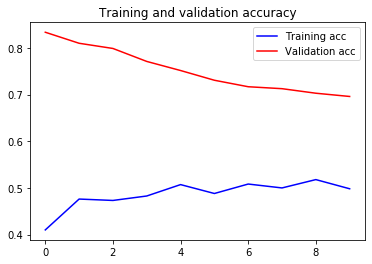

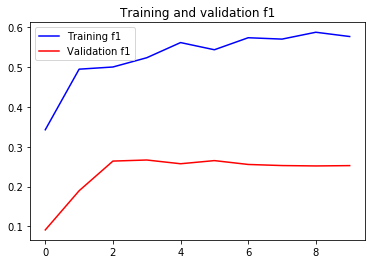

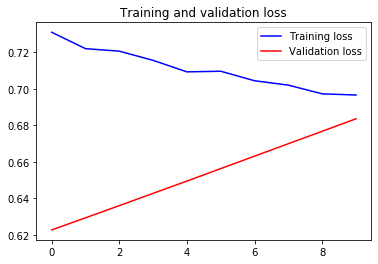

In [116]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [117]:
score = model.evaluate(X_test_sent_trans, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 8us/step

f1: 0.3376622796058655
accuracy: 0.4486486613750458
LOSS: 0.6950432062149048


In [118]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test_sent_trans, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test_sent_trans, verbose=0)

In [119]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [120]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [121]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.448649
Precision: 0.764706
Recall: 0.216667
F1 score: 0.337662
Kappa score: 0.071815


Text(0.5, 15.0, 'Predicted')

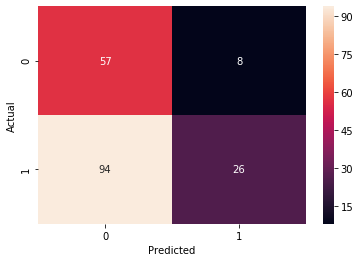

In [122]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### 5. Trans Sentiment Model + Cleaned Text

In [123]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [124]:
X_train_text_sent_trans.shape

(2400, 104)

In [125]:
type(X_train_text_sent_trans)

numpy.ndarray

In [126]:
# Reshaping X_train & X_test
X_train_text_sent_trans = X_train_text_sent_trans[:, :, None]
X_test_text_sent_trans = X_test_text_sent_trans[:, :, None]

In [127]:
X_train_text_sent_barasa.shape

(2400, 104, 1)

In [128]:
model = Sequential()
model.add(LSTM(10, dropout=0.2, input_shape=X_train_text_sent_trans.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [129]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', f1_m])

In [130]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train_text_sent_trans, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 1s 486us/step - loss: 0.7317 - accuracy: 0.4119 - f1_m: 0.3459 - val_loss: 0.6215 - val_accuracy: 0.8333 - val_f1_m: 0.0909
Epoch 2/10
1680/1680 [==============================] - 0s 107us/step - loss: 0.7226 - accuracy: 0.4762 - f1_m: 0.4950 - val_loss: 0.6284 - val_accuracy: 0.8069 - val_f1_m: 0.1871
Epoch 3/10
1680/1680 [==============================] - 0s 109us/step - loss: 0.7210 - accuracy: 0.4744 - f1_m: 0.5023 - val_loss: 0.6355 - val_accuracy: 0.7958 - val_f1_m: 0.2759
Epoch 4/10
1680/1680 [==============================] - 0s 130us/step - loss: 0.7157 - accuracy: 0.4845 - f1_m: 0.5265 - val_loss: 0.6427 - val_accuracy: 0.7597 - val_f1_m: 0.2575
Epoch 5/10
1680/1680 [==============================] - 0s 112us/step - loss: 0.7091 - accuracy: 0.5083 - f1_m: 0.5645 - val_loss: 0.6499 - val_accuracy: 0.7403 - val_f1_m: 0.2609
Epoch 6/10
1680/1680 [==============================]

In [131]:
save_model(model, 'model/LSTM smote_cbow_text_sent_trans')

Saved model to disk


In [132]:
history.history

{'val_loss': [0.6214986443519592,
  0.6283704042434692,
  0.6355233192443848,
  0.6427088379859924,
  0.6498762965202332,
  0.6571297645568848,
  0.6643792390823364,
  0.6716399192810059,
  0.6789178252220154,
  0.6862151026725769],
 'val_accuracy': [0.8333333134651184,
  0.8069444298744202,
  0.7958333492279053,
  0.7597222328186035,
  0.7402777671813965,
  0.7222222089767456,
  0.7166666388511658,
  0.7138888835906982,
  0.6986111402511597,
  0.6930555701255798],
 'val_f1_m': [0.09090904891490936,
  0.18713445961475372,
  0.27586203813552856,
  0.2575106918811798,
  0.2608695328235626,
  0.2592592239379883,
  0.25547441840171814,
  0.2589927613735199,
  0.24913491308689117,
  0.25589221715927124],
 'loss': [0.7317177800905137,
  0.7226308822631836,
  0.7210275457018898,
  0.7157133630343846,
  0.709097899709429,
  0.7092855532964071,
  0.7038453987666539,
  0.7011830494517372,
  0.6963308379763649,
  0.6953211409705026],
 'accuracy': [0.41190475,
  0.47619048,
  0.47440475,
  0.48452

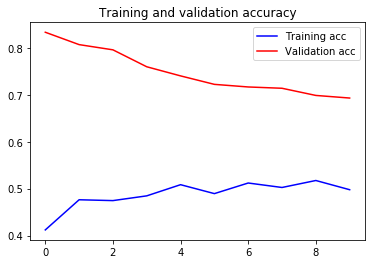

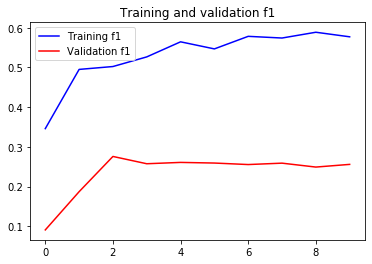

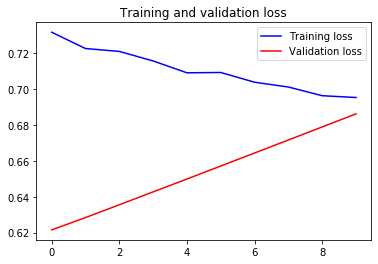

In [133]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [134]:
score = model.evaluate(X_test_text_sent_trans, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 55us/step

f1: 0.3483870327472687
accuracy: 0.454054057598114
LOSS: 0.6937772035598755


In [135]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test_text_sent_trans, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test_text_sent_trans, verbose=0)

In [136]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [137]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [138]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.454054
Precision: 0.771429
Recall: 0.225000
F1 score: 0.348387
Kappa score: 0.078422


Text(0.5, 15.0, 'Predicted')

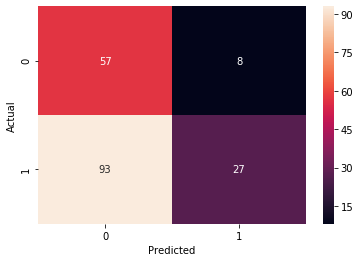

In [139]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')